In [4]:
"""
Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict
the number of international airline passengers in units of 1,000.
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

Stat library: https://www.statsmodels.org/stable/index.html
Need version 0.11 or later..
pip install statsmodels --upgrade

For pmdarima:
pip install pmdarima
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import pmdarima as pm
# from pmdarima.arima import ADFTest
# from pmdarima.arima import auto_arima


In [5]:
plt.style.use('dark_background')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# load the dataset
# Load the CSV file into a DataFrame
pd.set_option('display.max_rows', None)
csv_path = "/content/gdrive/MyDrive/Colab_Notebooks/AirPassengers.csv"

df = pd.read_csv(csv_path)
print(df.dtypes)

Month          object
#Passengers     int64
dtype: object


In [8]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

Month          datetime64[ns]
#Passengers             int64
dtype: object


In [9]:
df.set_index('Month', inplace=True)

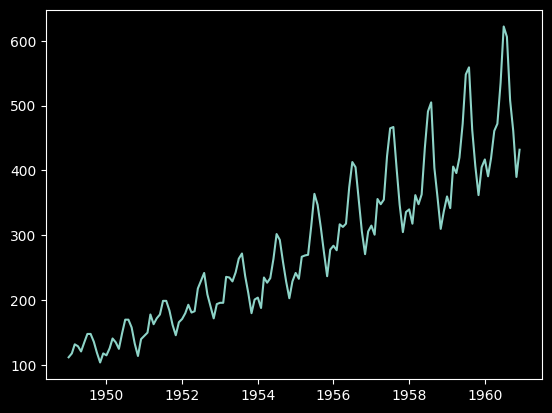

In [10]:
plt.plot(df['#Passengers'])
#The data seems to be non-stationary

In [ ]:
#One way of testing stationarity

#Is the data stationary?
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)
#Not stationary...

In [11]:
#Preferred way of checking stationarity in data

#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

#For stationary data, we can use ARIMA
#For seasonal or non-stationary data, we can use SARIMA and/or SARIMAX

pvalue =  0.991880243437641  if above 0.05, data is not stationary


In [13]:
#Extract and plot trend, seasonal and residuals individually (EDA step)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df['#Passengers'],
                            model ='additive')

In [14]:
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

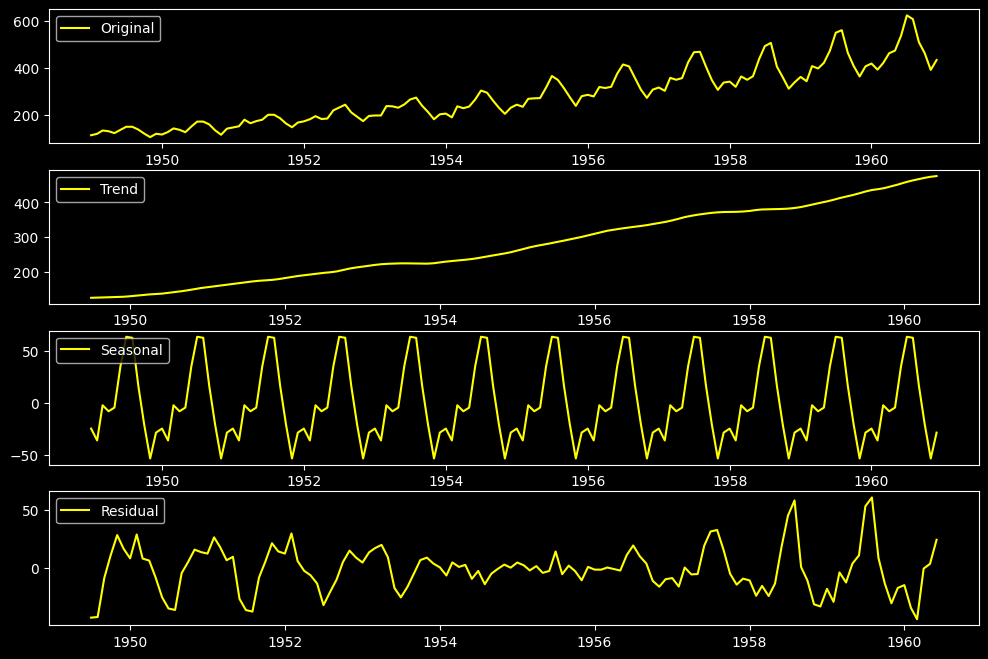

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

We can go through the exercise of making the data stationary and performing ARIMA or let auto_arima provide the best model (e.g. SARIMA) and parameters.

Auto arima suggests best model and parameters based on AIC metric (relative quality of statistical models)

In [ ]:
#Note : This code is not running because pmdarima is not installed well in Colab

from pmdarima.arima import auto_arima

#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving average terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['#Passengers'], start_p = 1, d=1, start_q = 1,
                          max_p = 5, max_q = 5, max_d=5, m = 12,
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True,
                          trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True, n_fits=50)

# To print the summary
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

In [17]:
#Split data into train and test
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

print(X_train.shape, X_test.shape)

(95, 1) (49, 1)


In [18]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(X_train['#Passengers'],
                order = (0, 1, 1),
                seasonal_order =(2, 1, 1, 12))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.268
Date:                            Sun, 23 Mar 2025   AIC                            610.537
Time:                                    02:32:31   BIC                            622.570
Sample:                                01-01-1949   HQIC                           615.368
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3197      0.102     -3.122      0.002      -0.520      -0.119
ar.S.L12       0.6851      0.598      1.145      0.252      -0.487       1.857
ar.S.L24       0.3139      0.138      2.281      0.023       0.044       0.584
ma.S.L12      -0.9816      5.672     -0.173      0.863     -12.099      10.135
sigma2        78.5187    398.628      0.197      0.844    -702.779     859.816
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.68   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index)

In [21]:
#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers')
#Rename the column

<Axes: xlabel='Month'>

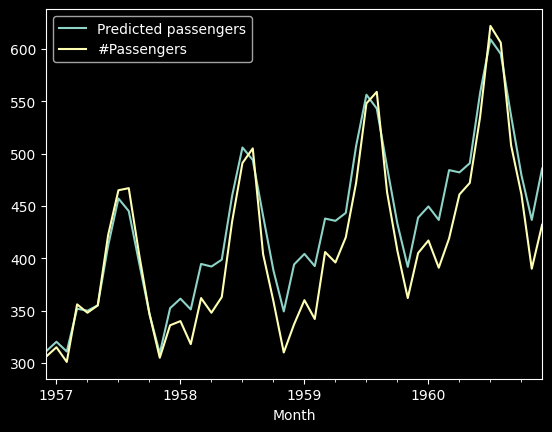

In [23]:
# plot predictions and actual values
prediction.plot(legend = True)
X_test['#Passengers'].plot(legend = True)

In [24]:
import math
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

#from sklearn.metrics import r2_score
#score = r2_score(X_test, prediction)
#print("R2 score is: ", score)

Train Score: 16.14 RMSE
Test Score: 29.50 RMSE


In [25]:
#Forecast.. You can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years

forecast = result.predict(start = len(df),
                          end = (len(df)-1) + 3 * 12,
                          typ = 'levels').rename('Forecast')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


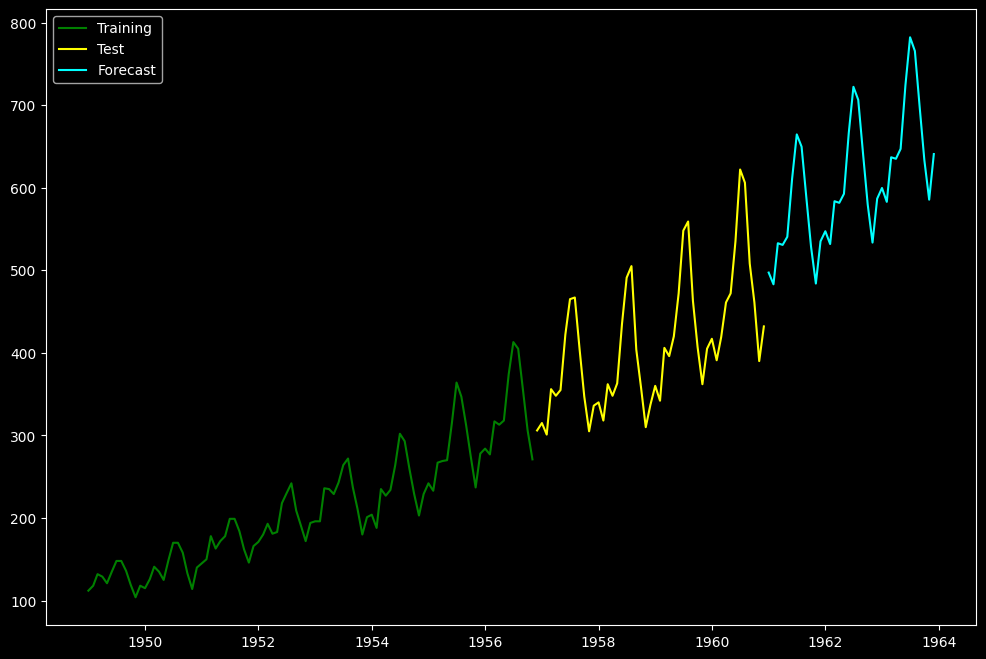

In [27]:

plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()